Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 112, 112, 64)      39232     
_________________________________________________________________
sequential_2 (Sequential)    (None, 56, 56, 128)       222464    
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 256)       1478400   
_________________________________________________________________
sequential_4 (Sequential)    (None, 14, 14, 512)       5905920   
_________________________________________________________________
sequential_5 (Sequential)    (None, 7, 7, 512)         7085568   
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              1

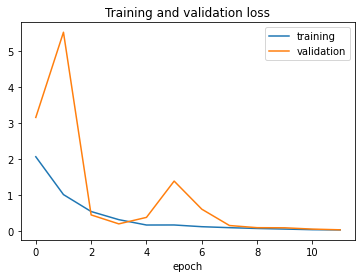

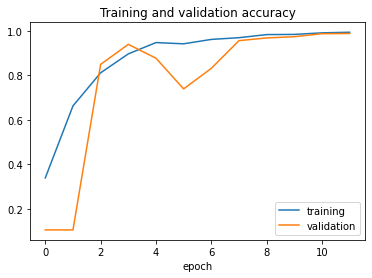

/kaggle/working/fish_model.h5

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import imgaug.augmenters as iaa
import imgaug as ia
import random
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Add
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras import activations
from keras import regularizers
import datetime


# Data Location for input
MyDrive = '/Output/working'
clear_output()
DataDir = '/content/drive/MyDrive/Fish_Dataset/Fish_Dataset'

def prepare_input(loc, divide_data):
    X = []
    y = []
    Frame = []
    
    flip = iaa.Fliplr(1.0)
    zoom = iaa.Affine(scale=1)
    random_brightness = iaa.Multiply((1, 1.2))
    rotate = iaa.Affine(rotate=(-20, 20))
    
    for i, category in enumerate(types):
        path = os.path.join(loc, category, (category))
        if not os.path.isdir(path):
            pass
        
        else:
            num_class = types.index(category)
            # limiting images from each class
            limit = 500 
            img_list = os.listdir(path)[0:limit]
            random.shuffle(img_list)
            
            for img in tqdm(img_list):
                img_original = cv2.imread(os.path.join(path,img) , cv2.IMREAD_COLOR)
                image_aug = cv2.resize(img_original, (IMG_SIZE, IMG_SIZE), interpolation = cv2.INTER_CUBIC)
                image_aug = flip(image = image_aug)
                image_aug = random_brightness(image = image_aug)
                image_aug = zoom(image = image_aug)
                image_aug = rotate(image = image_aug)
                image_aug = cv2.cvtColor(image_aug, cv2.COLOR_BGR2RGB)
                X.append(image_aug)
                y.append(num_class)
 
    if len(X) > 0:
        train_len = int(len(X) * divide_data)
        
        features = pd.DataFrame((np.array(X)).reshape(-1, IMG_SIZE * IMG_SIZE * ColorCh))
        labels = pd.DataFrame({'label': y})
        
        Frame = pd.concat([features, labels], axis=1).sample(frac = 1, random_state=73)     
        train_df, test_df = Frame[train_len:], Frame[:train_len]
        
        return train_df, test_df


# VGG-16 Architecture
def vgg_block(num_convs, num_channels):
    block = tf.keras.models.Sequential()
    for _ in range(num_convs):
        block.add(Conv2D(filters=num_channels, kernel_size=(3, 3), padding="same"))
        block.add(BatchNormalization())
        block.add(Activation('relu'))

    block.add(MaxPooling2D(pool_size=2, strides=2))
    return block


def VGG_MODEL(n_layers):
    conv_arch = ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
    vgg_model = Sequential()
    vgg_model.add(Input(shape=input_shape))
    for (num_convs, num_channels) in conv_arch:
        vgg_model.add(vgg_block(num_convs, num_channels))
    vgg_model.add(Flatten())
    vgg_model.add(Dense(units=4096))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Activation('relu'))
    vgg_model.add(Dropout(0.5, seed=73))
    vgg_model.add(Dense(units=4096))
    vgg_model.add(BatchNormalization())
    vgg_model.add(Activation('relu'))
    vgg_model.add(Dropout(0.5, seed=73))
    vgg_model.add(Dense(units=classes_no, activation=final_activation))
    return vgg_model


# Print Model Results by graphs
def print_graph(item, index, history):
    train_values = history.history[item][0:index]
    plt.plot(train_values)
    test_values = history.history['val_' + item][0:index]
    plt.plot(test_values)
    plt.legend(['training', 'validation'])
    plt.title('Training and validation ' + item)
    plt.xlabel('epoch')
    plt.show()


# Choosing epoch with best accuracy
def get_best_epoch(test_loss, history):
    for key, item in enumerate(history.history.items()):
        (name, arr) = item
        if name == 'val_loss':
            for i in range(len(arr)):
                if round(test_loss, 2) == round(arr[i], 2):
                    return i


# Printing the graph for accuracy and loss
def model_summary(model, history):
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    if history:
        index = get_best_epoch(test_loss, history)
        train_accuracy = history.history['accuracy'][index]
        train_loss = history.history['loss'][index]
        print('Best Epochs: ', index)
        print('Accuracy on train:',train_accuracy,'Loss on train:',train_loss)
        print('Accuracy on test:',test_accuracy,'Loss on test:',test_loss)
        print_graph('loss', index, history)
        print_graph('accuracy', index, history)


def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


# ## **Compile** and **Fit Model**
def CompileModel(model):
    model.summary()
    model.compile(optimizer='adam', loss=entropy,metrics=['accuracy'])
    return model


def FitModel(model, name):
    history = model.fit(X_train,y_train,
                              epochs=EPOCHS,
                              callbacks=callbacks,
                              batch_size = batch_size,
                              validation_data = (X_test, y_test),
                              )
    model.load_weights(checkpoint_filepath)
    final_accuracy_avg = np.mean(history.history["val_accuracy"][-5:])
    final_loss = history.history["val_loss"][-1]
    group = {history: 'history', name: 'name', model: 'model', final_accuracy_avg:'acc', final_loss:'loss'}
    clear_output()
    model.summary()
    return model, history

def BuildModel():
    if tpu_init:
        with tpu_strategy.scope():
            prepared_model = VGG_MODEL(16)
            compiled_model = CompileModel(prepared_model)
    else:
        prepared_model = VGG_MODEL(16)
        compiled_model = CompileModel(prepared_model)
    return compiled_model


# Initalizations
EPOCHS = 50
patience = 5
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 16
rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

tf.random.set_seed(73)
tpu_init = False
if tpu_init:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


# Separating 3 color channels from data
ia.seed(73)
IMG_SIZE = 224
ColorCh = 3
types = []
for list_ in os.listdir(DataDir):
    if not '.' in list_:
        types.append(list_)
random.seed(73)


# training only 80% of the data
train_df, test_df = prepare_input(DataDir, divide_data=0.2)

# Data Summary
label_train_cnt = pd.Series(train_df['label'].values.ravel()).value_counts()
classes_no = len(label_train_cnt)
label_count_test = pd.Series(test_df['label'].values.ravel()).value_counts()

# Data for training
X_train = train_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_train = train_df['label']

# Data for testing
X_test = test_df.drop(["label"],axis = 1).to_numpy().reshape(-1,IMG_SIZE,IMG_SIZE,ColorCh).astype(np.float32) / 255.0
y_test = test_df['label']
input_shape = X_train.shape[1:]

# Using tensor flow for regularization
kernel_regularizer = regularizers.l2(0.0001)
final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy'


# Call Backs
if tpu_init:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync


class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if ((logs.get('accuracy')>=0.999) | (logs.get('loss') <= 0.01)):
            print("\nLimits Reached cancelling training!")
            self.model.stop_training = True

end_callback = myCallback()

lr_plat = ReduceLROnPlateau(patience = 2, mode = 'min')

lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)

early_stopping = EarlyStopping(patience = patience, monitor='val_loss',
                                 mode='min', restore_best_weights=True, 
                                 verbose = 1, min_delta = .00075)


checkpoint_filepath = 'Fish_Weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

log_dir="logs/fit/" + '_' + datetime.datetime.now().strftime("%Y%m%d")  
tensorboard_callback = TensorBoard(log_dir = log_dir, write_graph=True, histogram_freq=1)

callbacks = [end_callback, lr_callback, model_checkpoints, tensorboard_callback, early_stopping, lr_plat]
    
if tpu_init:
        callbacks = [end_callback, lr_callback, model_checkpoints, early_stopping, lr_plat]


# Building Model
skip_training = False
mode = 'proMode'
compiled_model = BuildModel()
model, history = FitModel(compiled_model, 'vgg')
model_summary(model, history)
model.save('fish_model.h5')
from IPython.display import FileLink

# tensorflow model
FileLink(r'./fish_model.h5')